# Исследование данных о продаже компьютерных игр

**Цель исследования:** Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Продажи прогнозируются на следующий год. 

Неважно, прогнозируются ли продажи на 2017 год по данным 2016-го или же на 2027-й — по данным 2026 года. На основе имеющихся данных нужно отработать принцип работы с ними.

In [1]:
#подключаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

#настроим вывод
pd.options.display.float_format = '{:,}'.format
pd.set_option('display.max_columns', None)

#отключим предупреждения
#import warnings
#warnings.filterwarnings('ignore')

### Откроем файл и изучим общую информацию

In [2]:
#загружаем данные в датафрейм
data = pd.read_csv('C:/Users/Aleks/practicum/datasets/games.csv')

data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.0",Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,"1,985.0",Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.0",Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,"2,009.0",Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.0",Role-Playing,11.27,8.89,10.22,1.0,NaN,NaN,NaN
5,Tetris,GB,"1,989.0",Puzzle,23.2,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,"2,006.0",Platform,11.28,9.14,6.5,2.88,89.0,8.5,E
7,Wii Play,Wii,"2,006.0",Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,"2,009.0",Platform,14.44,6.94,4.7,2.24,87.0,8.4,E
9,Duck Hunt,NES,"1,984.0",Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


**Вывод:** данных для исследования достаточно, продолжаем работу.

### Выполним предварительную обработку датафрейма

In [3]:
#общие данные о датафрейме получены. Необходимо сразу привести названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

#### Обработаем пропуски и дубликаты

In [4]:
#проверим явные дубликаты
data.duplicated().sum()

0

В столбце "name", "genre" и "year_of_release" есть 2 пропуска. Эти строки сразу удалим, т.к. это одни из основных данных об игре, и рассматривать строки без них нет смысла.

In [5]:
data = data.dropna(subset=['name','genre','year_of_release'])

В стобцах с рейтингом пропуски обработать невозможно, т.к. это выражение мнения определенной когорты людей, и не может быть усреднено.

Не совсем ясна ситуация со столбцом 'rating'. Он содержит много значений NaN. Фактически это означает, что возрастной рейтинг игры неизвестен и не выяснялся. Подрбнее ознакомимся с его значениями.

In [6]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Наверное, самым верным решением для игр с неизвестным рейтингом поставить рейтинг "AO", то есть только для взрослых, ведь нам неизвестны подробности про игру. Однако нельзя быть таким однозначным, и присвоение одинакового рейтинга большому количеству игр явно отразится на результате исследования. Поэтому пропустим.

Проверим дубликаты по столбцам "name", "platform" и "year_of_release".

In [7]:
data[data.loc[:,{'name','platform','year_of_release'}].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,"2,012.0",Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


Обнаружился целый 1 дубликат! Посмотрим подробно по критериям

In [8]:
data.query('name == "Madden NFL 13" and platform == "PS3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,"2,012.0",Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,"2,012.0",Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


Где-то закралась ошибка.. строки с виду полностью одинаковые, но в [16230] явно не хватает данных. Удалим.

In [9]:
data = data.drop([16230])
data = data.reset_index(drop=True)

**Вывод:** пропуски, где возможно, заполнены. Дубликаты и пустые значения удалены.

#### Изменим типы данных на необходимые

Посмотрим на содержимое столбцов. Необходимо изменить типы данных в следующих столбцах:
- year_of_release - можно преобразовать в datetime, для удобства работы с датами, но в дальнейшем придется неудобно извлекать год. Поэтому преобразуем в int
- в стобцах *sales* - это млн. Оставим как есть, но имеем ввиду единицу измерения.
- critic_score - только целочисленные значения, но содержит NaN - оставим как есть
- user_score - это явно число, преобразуем в цифровой формат.


In [10]:
data['year_of_release'] = data['year_of_release'].astype('int')

Со столбцом user_score чуть сложнее. Посмотрим на список значений.

In [32]:
data['user_score'].unique()

array([8.2, 8.1, nan, 8.3, 2.6, 4.3, 5.7, 5. , 6.5, 9.1, 6.1, 7.9, 5.4,
       8.4, 6.4, 3.4, 8.5, 4.8, 9. , 4.9, 4.5, 6.2, 4.2, 6.3, 7.7, 9.2,
       7.6, 8.7, 6.7, 3.7, 7. , 6.9, 4.1, 5.8, 5.6, 6.8, 5.5, 7.5, 4.4,
       5.9, 7.2, 8.9, 3.9, 7.8, 3.2, 8.6, 3.1, 7.4, 7.3, 6.6, 6. , 4.7,
       7.1, 8.8, 5.1, 3. , 2.9, 2.7, 2.2, 8. , 3.5, 5.2, 5.3, 3.8, 4.6,
       3.3, 9.3, 4. , 3.6, 2.4, 2.8, 1.8, 1.7, 1.6, 2.1, 2. , 1.5, 0.7,
       2.5, 0.2, 1.9, 1.3, 1. , 1.4, 2.3])

Видим tbd, видимо здесь имеется ввиду аббревиатура "to be determined" - "подлежит уточнению". Фактически рейтинг неизвестен. Т.к. для использования рейтинга в исследовании его в любом случае предполагается перевести в число, можно просто обработать данные значения как неизвестные, то есть по сути NaN.

In [12]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

#и сразу проверяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int32  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           9767 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


**Вывод:** данные приведены к требуемым типам, наименования столбцов к "змеиному регистру". Продолжаем.

#### Добавим столбец с сумарным числом продаж

Это потребуется в дальнейшем.

In [13]:
data['all_sales']=data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

### Исследовательский анализ данных

#### Оценим распределение выпуска игр по годам

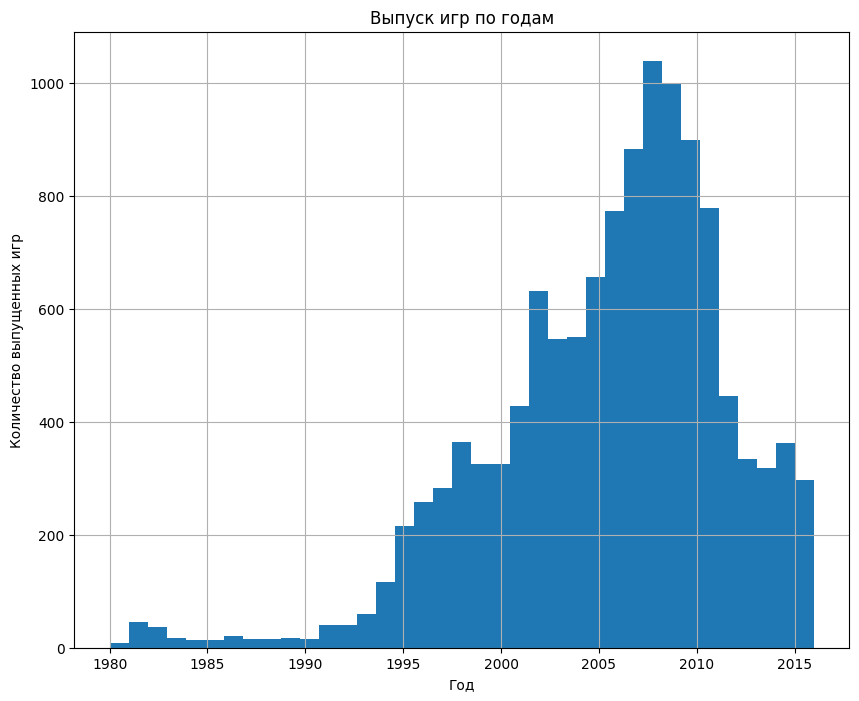

In [14]:
#посчитаем количество корзин для гистограммы
bins = (
    data['year_of_release'].max() - data['year_of_release'].min() + 1
)

#сделаем расчёт исключительно по названию игр в год, исключаем дубликаты,
# т.к. например может выходить одна игра на разных платформах
plt.title('Выпуск игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество выпущенных игр')
data.drop_duplicates(subset=['name','year_of_release'], keep='first')['year_of_release']\
.hist(range=(data['year_of_release'].min(),data['year_of_release'].max()), bins=bins, figsize=(10,8));


**Вывод:** До 1992 года игры выпускались в малых количествах, а с 1990 начался рост выпуска игр. Основная часть игр была выпущена с 1996 по 2016 годы, пик пришёлся на 2008 год.

#### Найдем самые прибыльные платформы в прошлые годы


In [15]:
#найдем 10 самых прибыльных платформ за прошлые годы
top_platforms = (
    data.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values(by='all_sales',ascending=False)\
    .reset_index().round(2).head(10)
)
top_platforms

,platform,all_sales
0,PS2,"1,233.56"
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


In [16]:
#в таблице видим сильный отрыв первых 6 платформ. Будем рассматривать только их, как перспективные
top_platforms = top_platforms['platform'].head(6)

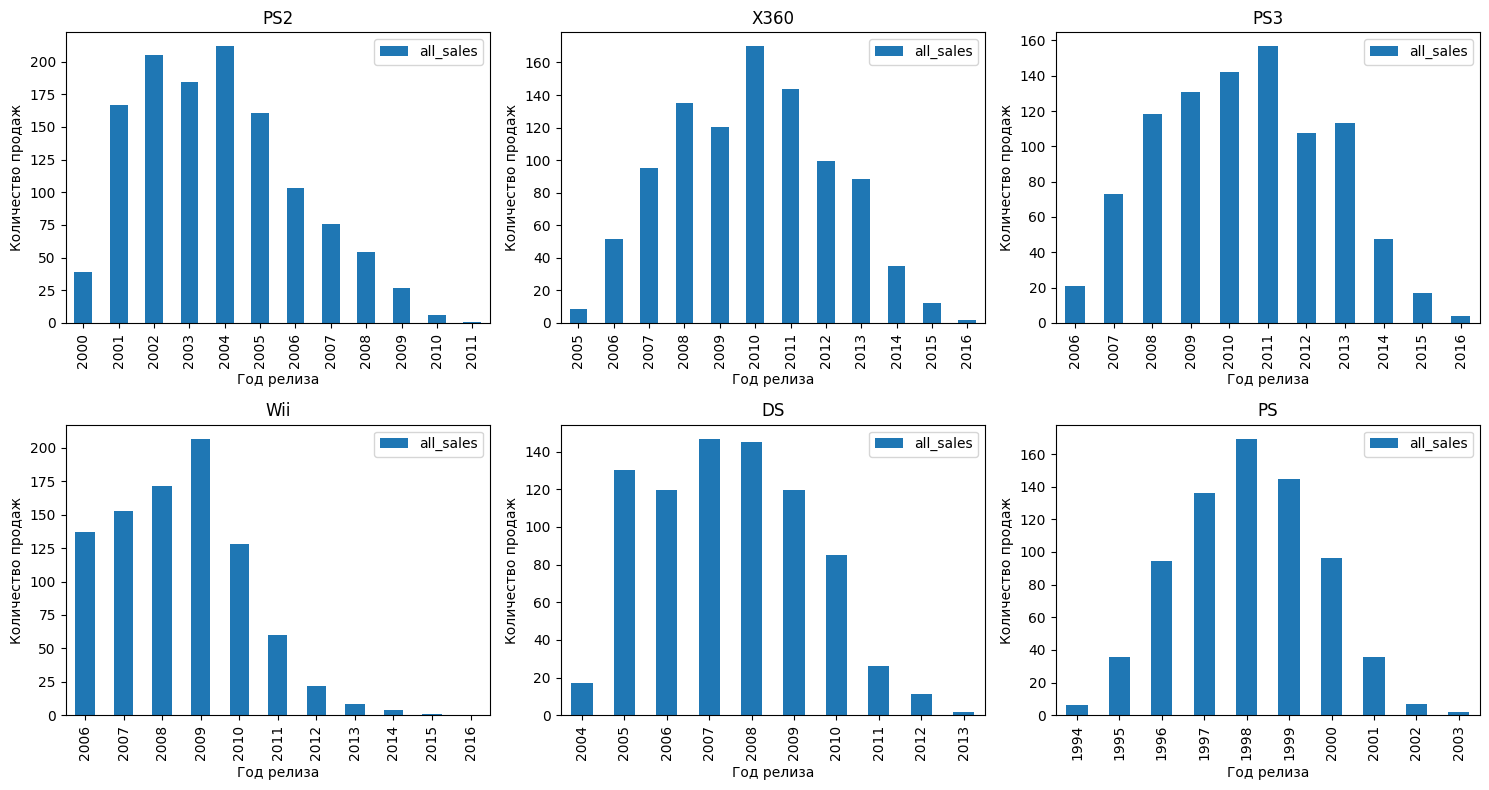

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(15,8))
ax = ax.flatten()

for i, platform in enumerate(top_platforms):
    data.query('year_of_release > 1990 and platform == @platform')\
    .pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')\
    .plot(kind='bar', title=platform, ax=ax[i], xlabel='Год релиза', ylabel='Количество продаж')
fig.tight_layout()
plt.show()



**Вывод:** По платформам с максимальным объемом продаж можно с сказать, что они появляются и исчезают за 8-10 лет. Остановимся на цифре в 8 лет, т.к. в последние годы существования платформы продажи уже незначительные. С учетом того, что пик продаж приходится примерно на середину этого срока, для дальнейшего анализа будем использовать данные из 2013-2016 годов (период роста продаж в первые 4 года).

In [33]:
# теперь перепишем датафрейм, с учетом фильтра по годам
data = data.query('year_of_release >= 2013')

#### Поиск перспективных платформ

In [19]:
#строим сводную таблицу по количеству продаж и сортируем по убыванию
perspective_platform = data.pivot_table(index='platform', values='all_sales', aggfunc='sum')\
.sort_values(by='all_sales',ascending=False).round(2).head(10).reset_index()
perspective_platform

,platform,all_sales
0,PS4,314.14
1,PS3,181.43
2,XOne,159.32
3,3DS,143.25
4,X360,136.8
5,WiiU,64.63
6,PC,39.43
7,PSV,32.99
8,Wii,13.66
9,PSP,3.5


Топ по продажам еще не означает, что платформа будет перспективна, т.к. возможно её жизненный цикл уже подходит к финалу. Поэтому аналогично предыдущему пункту в анализе построим диаграммы по платформам.

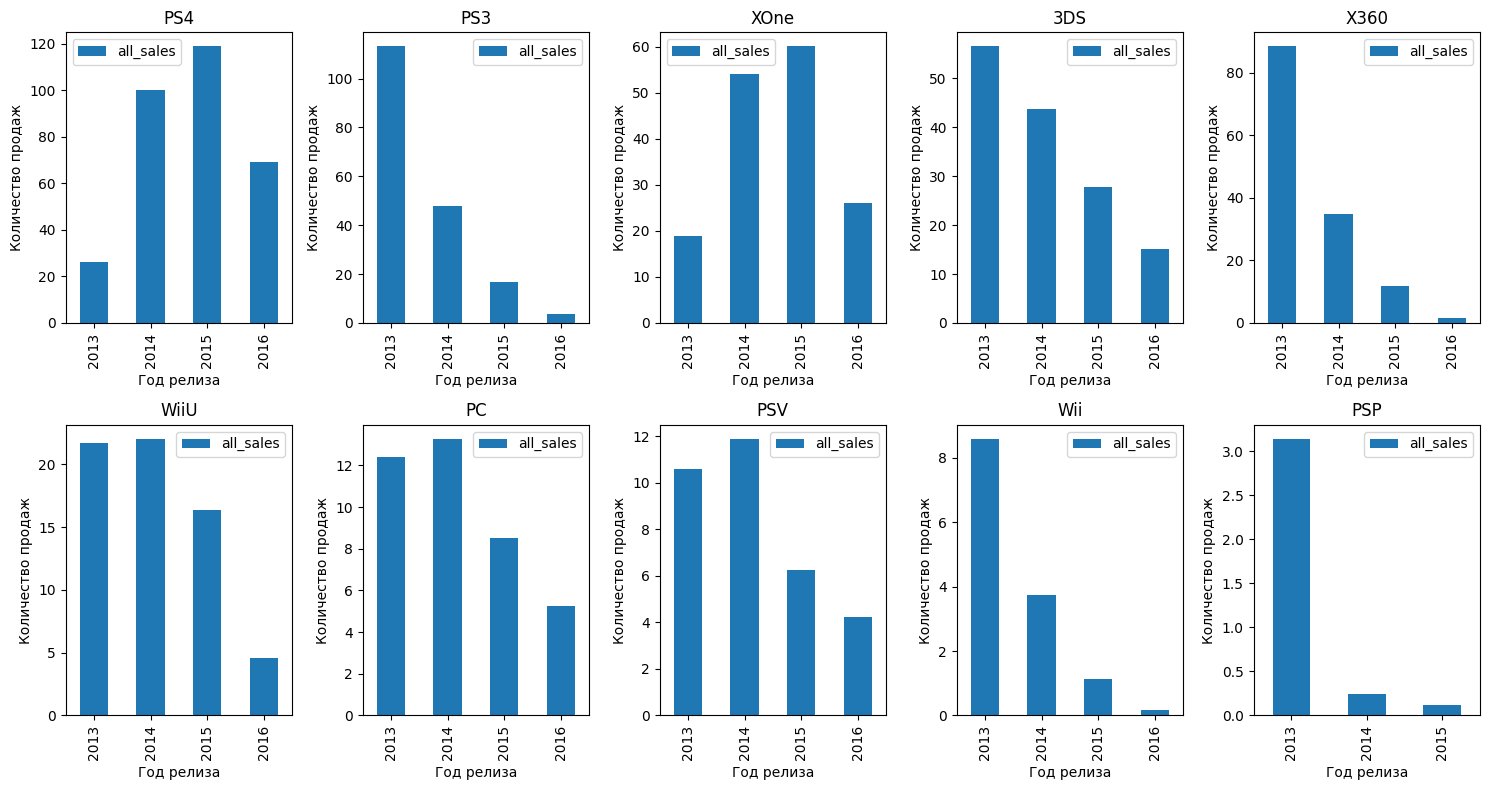

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(15,8))
ax = ax.flatten()

for i, platform in enumerate(perspective_platform['platform']):
    data.query('platform == @platform')\
    .pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')\
    .plot(kind='bar', title=platform, ax=ax[i], xlabel='Год релиза', ylabel='Количество продаж')
fig.tight_layout()
plt.show()

Проанализируем состояние платформ на 2017 год:
- PS4 находится в середине жизненного цикла
- XOne находится в середине жизненного цикла
- PC и PSV вероятнее всего будут актуальны еще пару лет
- 3DS уже в стадии угасания, но продажи пока имеют место.

Остальные платформы уже прошли пик продаж и теряют актуальность.

**Вывод**: Перспективными по объему продаж выглядят PS4, PS3, XOne, 3DS, X360. Однако X360 находится в состоянии угасания, и с учетом объема продаж я бы остановился на списке PS4, XOne, 3DS, PC.

#### Оценим глобальные продажи по перспективным платформам

Строим 2 графика, один с выбросами, второй "усеченный" для более удобной оценки.

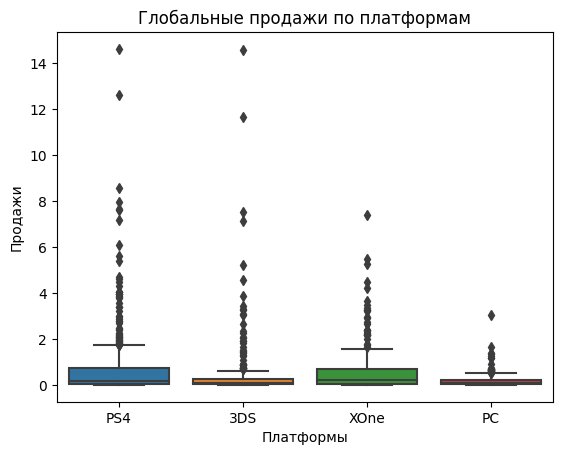

In [44]:
perspective_platform = ['PS4', 'XOne', '3DS', 'PC']
sns.boxplot(data = data.query('platform in @perspective_platform'), x='platform', y='all_sales').\
set( title='Глобальные продажи по платформам', xlabel='Платформы', ylabel='Продажи')
plt.show()

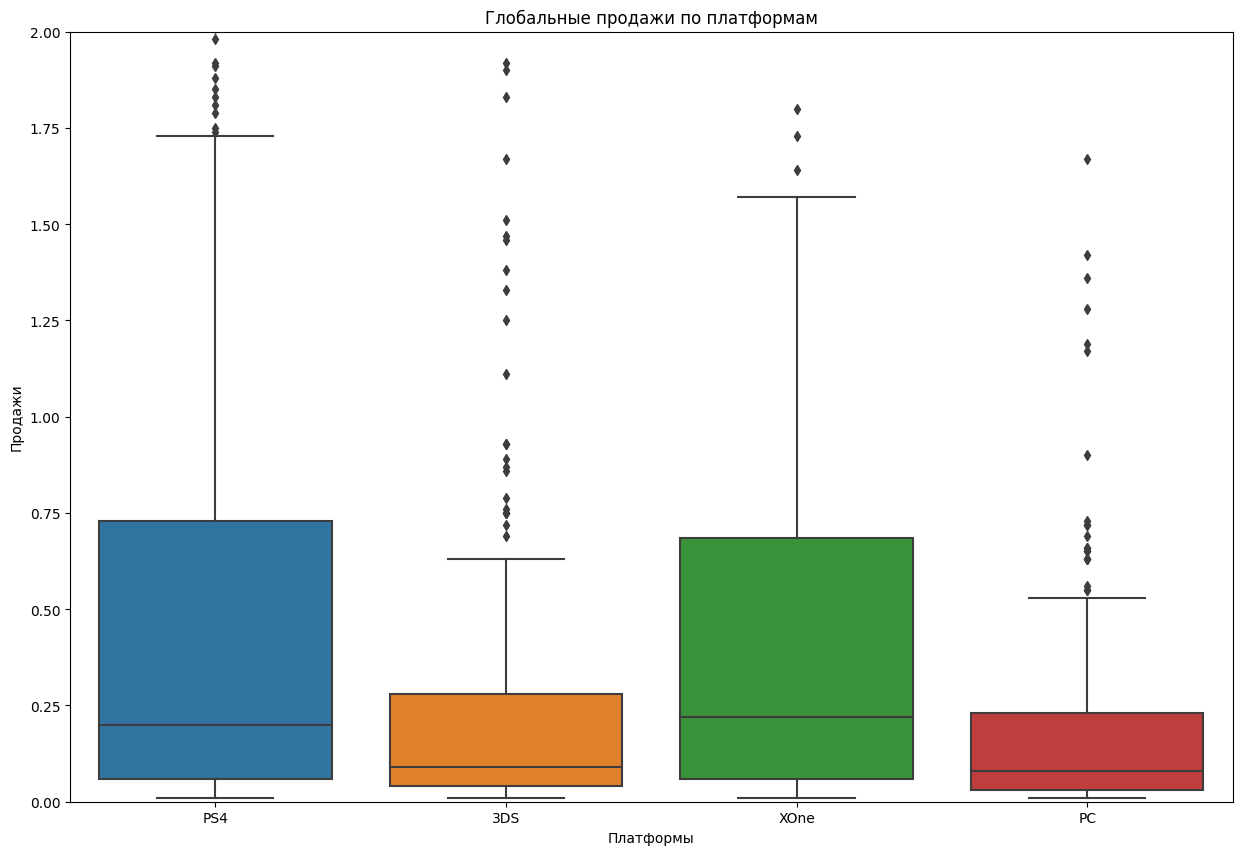

In [42]:
perspective_platform = ['PS4', 'XOne', '3DS', 'PC']
plt.figure(figsize=(15,10))
sns.boxplot(data = data.query('platform in @perspective_platform'), x='platform', y='all_sales').\
set(ylim=(0, 2), title='Глобальные продажи по платформам', xlabel='Платформы', ylabel='Продажи')
plt.show()

**Вывод:** По графику можно сделать вывод об объемах продаж игр на различных платформах. Итак, самыми популярными у покупателя будут игры на платформе XOne и PS4 (вывод на основе медианы и 75% квартиля). А вот самыми непопулярными - игры на PC и 3DS.

#### Влияние отзывов пользователей и критиков на продажи игр для PS4 и других платформ

Оценим влияние рейтинга на PS4 и другие платформы из списка перспективных.

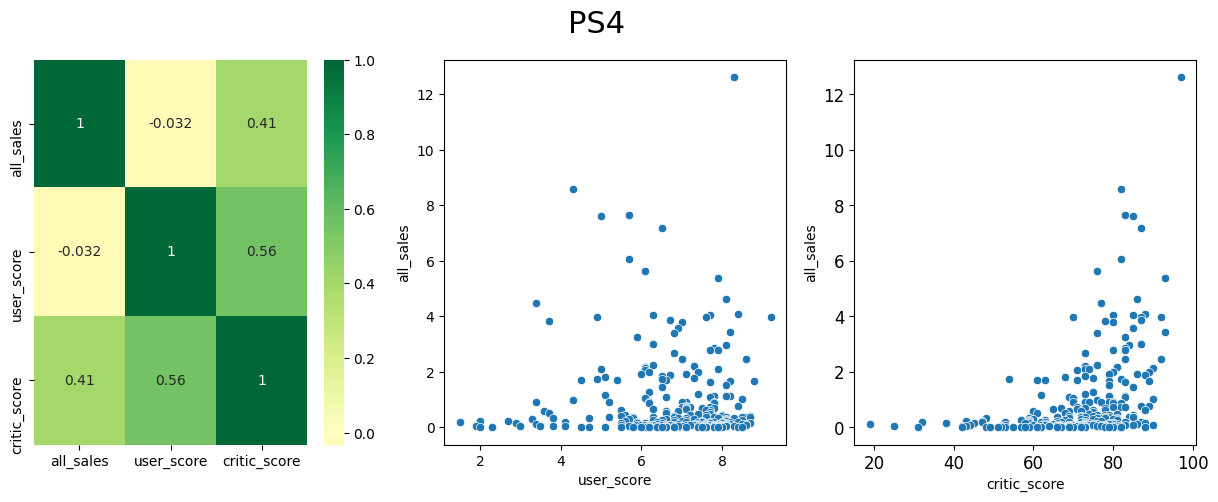

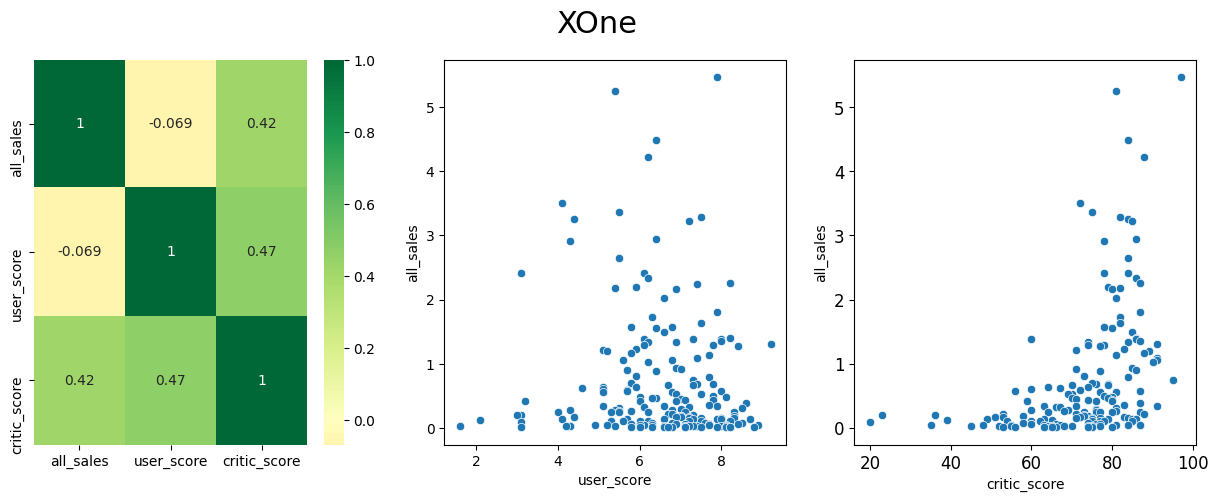

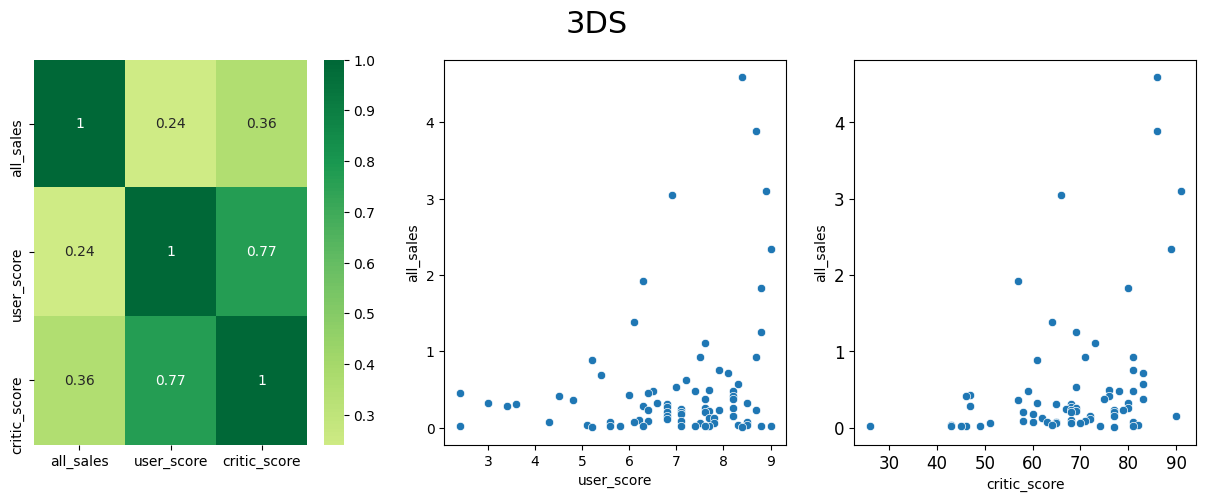

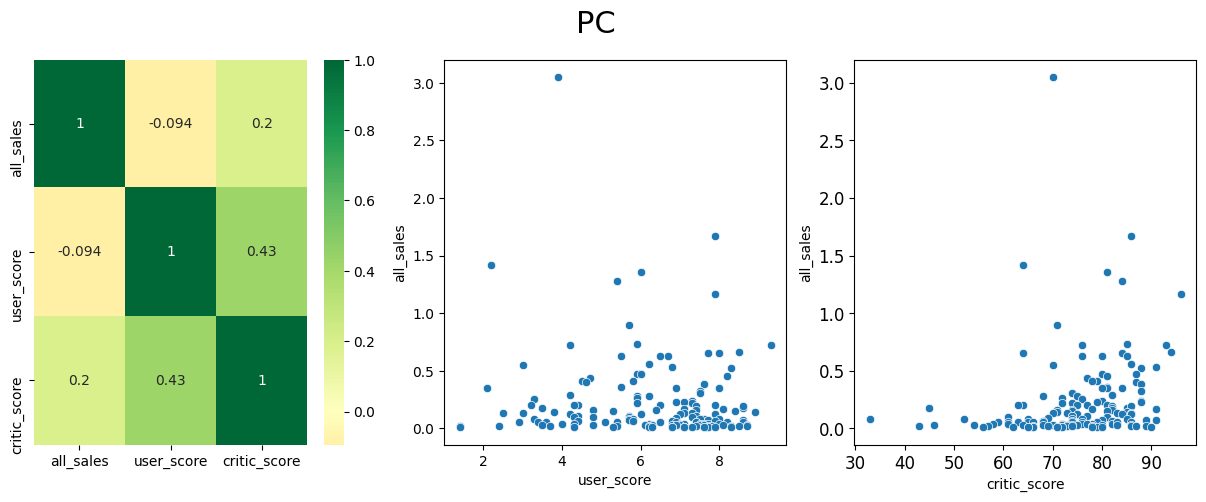

In [22]:
#пройдемся в цикле по всем платформам и построим матрицы корреляции
def platform_matrix(name_of_platform):
    platform = data.loc[data['platform'] == name_of_platform]
    platform = platform[['all_sales', 'user_score', 'critic_score']]
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(name_of_platform, fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    sns.heatmap(ax=ax[0], data=platform.corr(), xticklabels=platform.corr().columns, yticklabels=platform.corr().columns, cmap='RdYlGn', center=0, annot=True)    
    sns.scatterplot(ax=ax[1],x='user_score', y='all_sales', data=platform)    
    sns.scatterplot(ax=ax[2], x='critic_score', y='all_sales', data=platform)

    plt.show()


for platform in perspective_platform:
    platform_matrix(platform)

**Вывод:** У платформ PS4, XOne, 3DS, оценки критиков слабо коррелируют с объемом продаж. А вот оценки пользователей с продажами коррелируют очень слабо, можно сказать влияния почти не оказывают.
У платформы PC очень слабая корреляция любых оценок с объемами продаж.

#### Распределение игр по жанрам, зависимость продаж от жанра

Посмотрим на количество выпущенных игр разных жанров за целевой период.

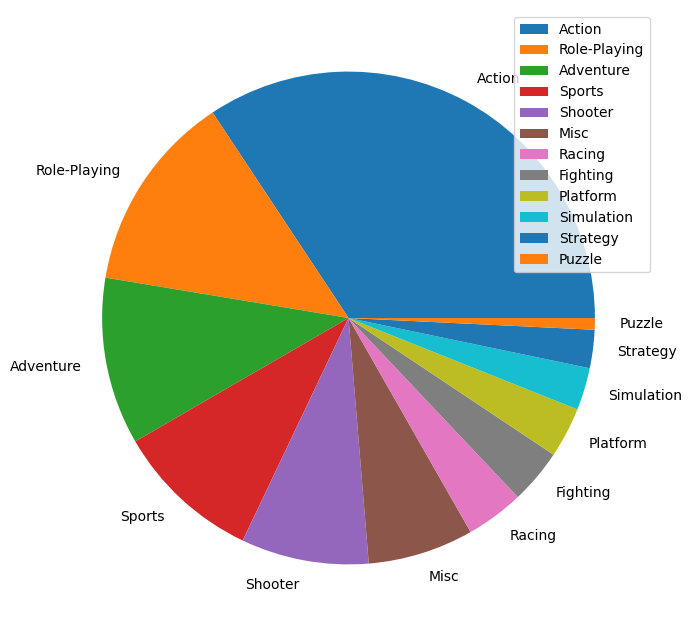

In [23]:
#построим диаграмму пирог для лучшей визуализации
temp = data.pivot_table(index='genre', values='name', aggfunc=['count'])\
.droplevel(level=1, axis=1).sort_values(by='count', ascending=False)
temp.plot(kind='pie', y='count', figsize=(8,8), ylabel='');

In [24]:
temp.rename(columns={'count':'Выпущено, шт'}).rename_axis('Жанр')

,"Выпущено, шт"
Жанр,
Action,766
Role-Playing,292
Adventure,245
Sports,214
Shooter,187
Misc,155
Racing,85
Fighting,80
Platform,74


**Вывод:** В лидерах по количеству выпущенных игры - экшн и приключенческие игры. А совсем мало выпущено стратегий и пазлов(логических игр).

Теперь оценим количество продаж по жанрам.

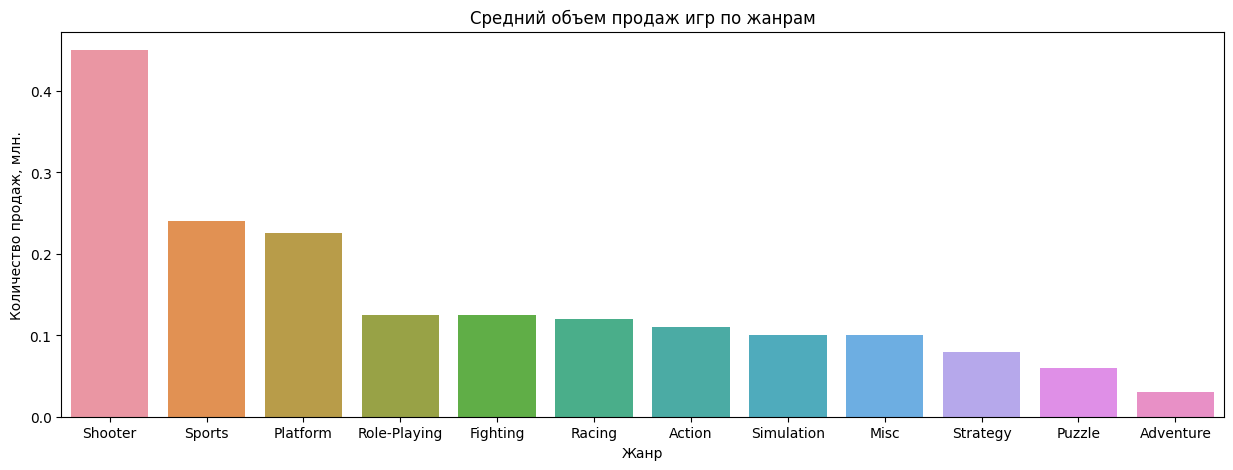

In [25]:
temp = data.pivot_table(index='genre', values='all_sales', aggfunc='median').sort_values(by='all_sales', ascending=False)\
.reset_index()
plt.figure(figsize=(15,5))
plt.title('Средний объем продаж игр по жанрам')
sns.barplot(data=temp, y='all_sales', x='genre')
plt.xlabel('Жанр')
plt.ylabel('Количество продаж, млн.');

**Вывод:** По среднему показателю продаж самый прибыльный жанр - шутеры. Чуть меньше продаж у спортивных игр и платформеров. А вот минимальное число продаж - у приключенческих игр.

### Портрет пользователя в каждом регионе

#### Самые популярые платформы в Японии, Европе и Северной Америке

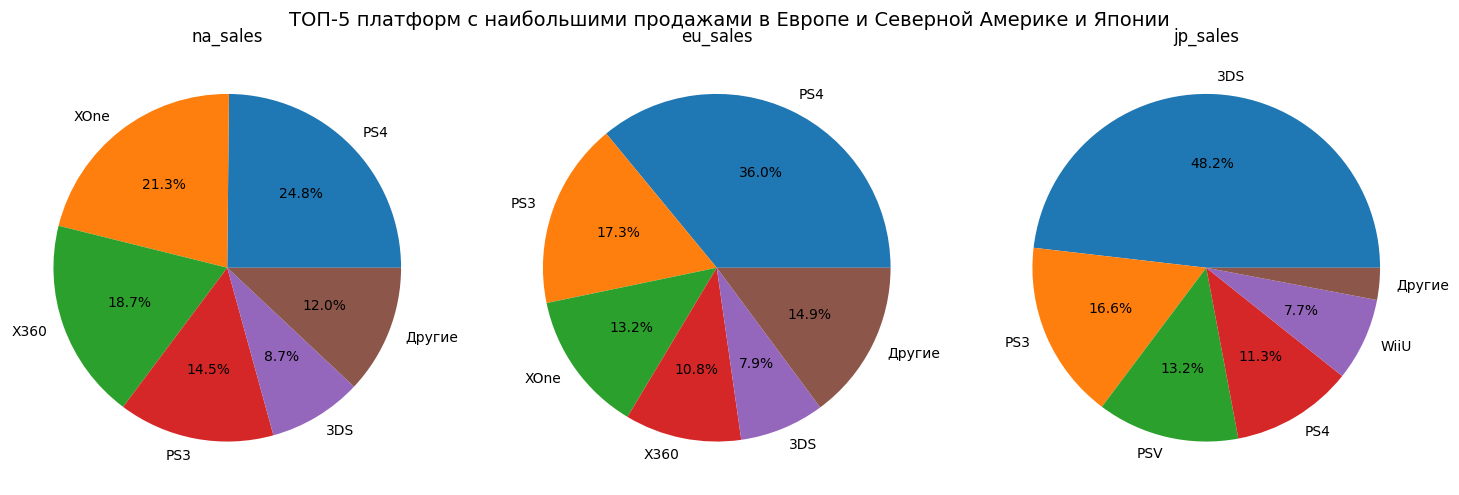

In [26]:
regions_sales = ['na_sales','eu_sales','jp_sales']


def user_portrait(category, name):
    fig, ax = plt.subplots(1, len(regions_sales),figsize=(15,5))
    for i, region in enumerate(regions_sales):
        temp = data.groupby(category).agg({region:'sum'}).sort_values(by=region,ascending=False).reset_index()
        temp.loc[5] = ['Другие', temp.loc[5:][region].sum().round(2)]
        temp = temp.head(6)        
        ax[i].pie(temp[region], labels=temp[category], autopct=lambda x: f'{x:.1f}%' if x > 5 else None)
        ax[i].set_title(region)
    plt.suptitle(name, fontsize=14)
    fig.tight_layout()
    plt.show()
        

user_portrait('platform','ТОП-5 платформ с наибольшими продажами в Европе и Северной Америке и Японии')

**Вывод:** Самые популярные платформы:
- в Северной Америке - PS4 и XOne
- в Европе - PS4
- в Японии - 3DS


В целом видна зависимость популярных платформ от региона. Вероятнее всего это связано с происхождением платформы и спецификой места, где пользователи играют, например Nintendo 3DS - японская носимая платформа, игроки могут брать её с собой.
А вот в Европе же популярна PS4, скорее всего игроки там предпочитают непринужденную домашнюю обстановку.

#### Самые популярные жанры в Японии, Европе и Северной Америке

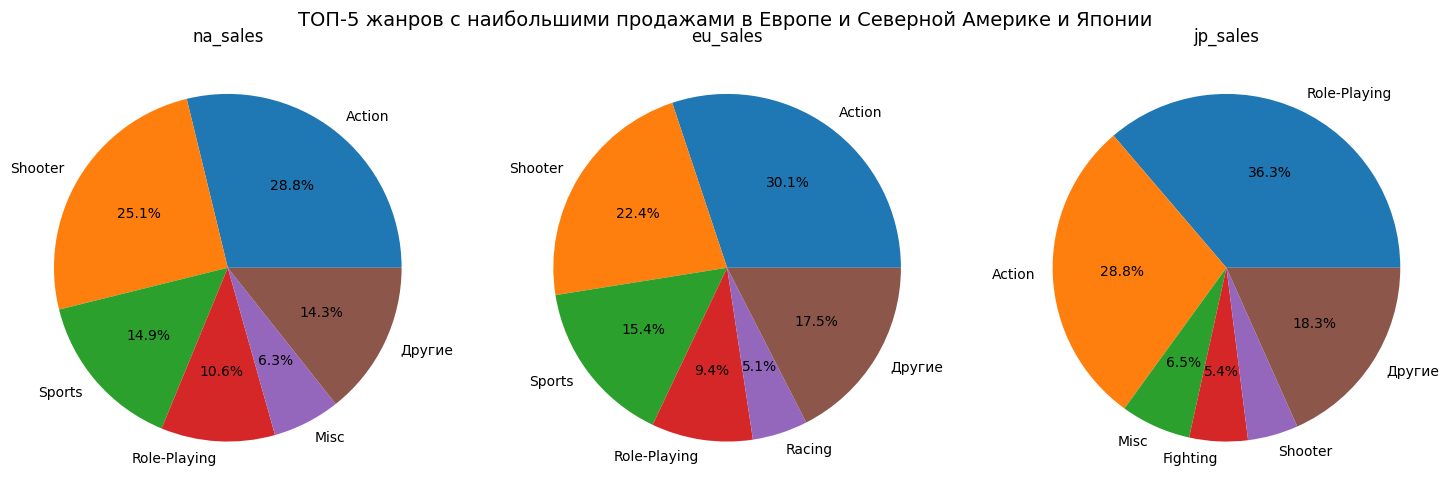

In [27]:
user_portrait('genre','ТОП-5 жанров с наибольшими продажами в Европе и Северной Америке и Японии')

**Вывод:** Аналогичная ситуация наблюдается и по жанрам: в Японии популярны ролевые игры, в Северной Америке и Европе - шутеры и спорт. А вот экшн популярен везде.

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Для начала посмотрим, каких возрастных рейтингов игры есть в продаже.

In [28]:
data['rating'].unique()

array(['M', nan, 'E', 'T', 'E10+'], dtype=object)

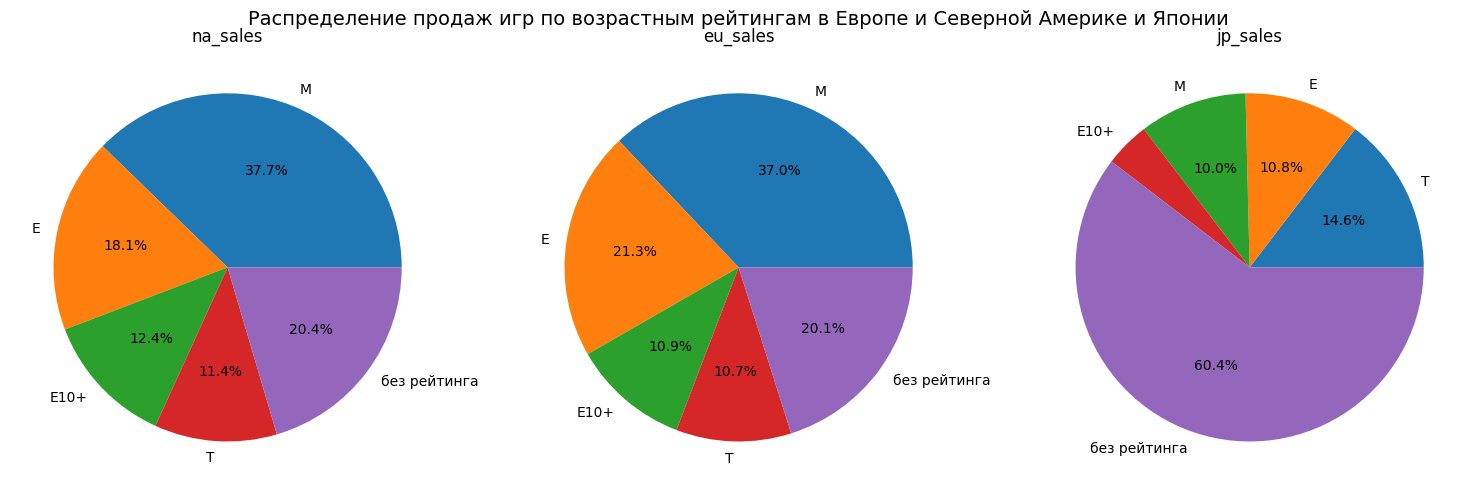

In [29]:
#получили 4 рейтинга, к сожалению готовую функцию использовать не можем.
fig, ax = plt.subplots(1, len(regions_sales),figsize=(15,5))
for i, region in enumerate(regions_sales):
    temp = data.groupby('rating').agg({region:'sum'}).sort_values(by=region,ascending=False).reset_index()
    temp.loc[4] = ['без рейтинга', data.loc[data['rating'].isna(),region].agg({region:'sum'})]
    ax[i].pie(temp[region], labels=temp['rating'], autopct=lambda x: f'{x:.1f}%' if x > 5 else None)
    ax[i].set_title(region)
plt.suptitle('Распределение продаж игр по возрастным рейтингам в Европе и Северной Америке и Японии', fontsize=14)
fig.tight_layout()
plt.show()


**Вывод:** Игры покупают разные возрастные категории - в Европе и Северной Америке это в основном 17+, а вот в Японии - 13+. 
Заметим, что в Северной Америке и Европе распределение практически идентичное (вероятно это связано с похожей аудиторией и системой возрастного рейтинга).
Также можно заметить взаимосвязь с выводом из п. 4.1, т.к. на носимые устройства подростку можно взять с собой и вероятно именно этим обусловлен объем продаж рейтинга "T" в Японии.

Кроме того, в Японии большинство игр вообще не имеют рейтинга ESRB (в Японии действует локальная система рейтингов CERO).

### Статистический анализ данных. Проверка гипотез.

#### Проверка гипотезы: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые".

Сформулируем гипотезы: 

H_0: Средний [user_score] платформы XOne = средний [user_score] платформы PC<br>
H_a: Средний [user_score] платформы XOne ≠ средний [user_score] платформы PC<br>
alpha = 0.05<br>

Для проверки воспользуемся t-тестом

In [30]:
# для начала почистим все пустые значения в требуемом столбце.
temp = data.dropna(subset=['user_score'])
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    temp.loc[(temp['platform'] == 'XOne'),'user_score'], 
    temp.loc[(temp['platform'] == 'PC'),'user_score'],
    equal_var = False
)
# alpha = задайте значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Нулевую гипотезу отвергнуть не получилось, делаем вывод, что вероятнее всего рейтинги отличаются минимально.

#### Проверка гипотезы: "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные."

Сформулируем гипотезы: 

H_0: Средний [user_score] жанра Action = средний [user_score] жанра Sports<br>
H_a: Средний [user_score] жанра Action ≠ средний [user_score] жанра Sports<br>
alpha = 0.05<br>

Для проверки воспользуемся t-тестом

In [31]:
# для начала почистим все пустые значения в требуемом столбце.
temp = data.dropna(subset=['user_score'])
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    temp.loc[(temp['genre'] == 'Action'),'user_score'], 
    temp.loc[(temp['genre'] == 'Sports'),'user_score'],
    equal_var = False
)
# alpha = задайте значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

1.4460039700704318e-20
Отвергаем нулевую гипотезу


**Вывод:** отвергаем гипотезу о равенстве рейтингов жанров Action и Sports. Средние рейтинги этих жанров с большой вероятностью имеют значительное различие.

### Общий вывод

Проведено исследование данных из открытых источников с целью выявления закономерностей, выявляющих успешность выпущенной игры.

Полученных данных для исследования было достаточно, основные пропуски были в рейтинге пользовательском и рейтинге критиков, а также в возрастном рейтинге игры.
Причина пропусков - данные не были указаны изначально.

Основная часть игр выпущена с 1990 года по 2016, пик был в 2008 году.

Самые прибыльные платформы за всё время PS2, X360, Wii, PS3, DS, PS.

В среднем срок жизни платформы 8-10 лет. В рамках исследования для выявления закономерностей возьмем срок 4 года(половина времени жизненного цикла платформы).

Самыми перспективными платформами с точки зрения продаж оказались PS4, XOne, 3DS, PC. Самые популярные жанры с точки зрения продаж по миру - shooter, sports, platform.

Однако следует учитывать, что популярность разных жанров и платформ меняется в зависимости от региона(подробнее п.п. 4.1, 4.2).

В п. 5 исследования проверены гипотезы зависимости рейтингов от платформы Xbox One и PC, а также жанра - action.
С высокой вероятностью рейтинг зависит от жанра, и не зависит от платформы.
